# TITLE HERE XXX

## To do
- Clarify terminology on UK vs England
- Terminology: phenology and productivity are not the same - I am using productivity here (but also caluclating phenology parameters)
- On biodiversity metric calculations, think about whether I should include other covariates (e.g. land use at the pan-trap location) am I comparing like for like? I.e. what else might affect insect diversity (other than S2 phenology parameters on nearby spring cereal fields) and how to remove effect of that?
- Present the methodology here after showing something that works as a hypothetical extension
- Add a summary of this notebook to the RS for agriculture part I

## Introduction
The land-sharing vs. land-sparing debate has received a lot of attention in recent years CITE. DEFINE.
https://www.cam.ac.uk/research/news/relocating-farmland-could-turn-back-clock-twenty-years-on-carbon-emissions


Complex tradeoffs exist e.g. between food security, economics for agricultural businesses and communities, agricultural sustainability and nature impacts and dependencies.

Here weigh in on the LS/LS debate: "having volunteered with several agricutlural business focussing on low-input, extensive practices, I've seen first-hand the effects of .... " but management decisions taken at an individual property level may not take account of larger scale patterns (for instance a farm in a prime-production region opting for extensive management, locally benefiting biodiversity but forfeiting productivity, resulting in supply leakage and land-conversion elsewhere which may offset local benefits); a policy that is coherent at a higher spatial-scale is needed to ensure a globally beneficial solution satisfing food production requirements, biodiversity goals and social economic factors.


Data-centric tools can be a key tool to aid in that decision-making processes. In particular, increasing availability of remote sensing data and biodiversity survey data. We can answer questions like where should we maximise food production, where should we prioritise rewilding efforts or soil health restoration - should we implement blanket policies (i.e. every farm should move towards regenerative methods), or opt for hetergenous strategies (fully rewild some areas, farm extensively in others and intensively in the rest). How do these decisions effect conservation and restoration efforts at a national and international scale, what are the social and economic implications for farming communities and society as a whole.


Here I investigate one facet of this complex question, making use of remote sensing, agricultural data and biodiversity surveys on the UK to look at the relationship between agricultural management, biodiversity and land-use patterns.

The UK is one of the most biodiversity depleted countries in the world CITE, with a significant portion of its surface dedicated to agriculture CITE, so this is a pertinent question to investigate. Furthermore there is significant appetite in the UK for changing agricultural practices CITE, and whilst the government has introduced policy in line with that trend CITE, key questions remain around the LS/LS debate.



__what does this notebook show - what are the results and conclusions? e.g. I found a correlation between x and y, and identified priority areas for changing ag strategies__

__Objectives__ </br>
a. 
Can the approach presented in [1], which links remote sensing parameters with biodiversity survey data, be applied to UK Pollinator Monitoring Scheme (PMS) data? To this end, I replicate the methodolgy in [1] to generate remote sensing crop productivity parameters, compute similar biodiversity metrics on PMS data and test the correlation between the resulting datasets.

b.
Present an example of a large-spatial scale product that may be used to inform ag policy with biodiversity in mind (IYR). Look at IYR values on PMS data localities (potentially for this one look a PMS citizen science data instead of trap data). Identify areas for de-intensification of farming.:

Looking at the distribution of PMS sampling locations with reference to honeybee-specific pesticide input to crop yield ratios (IYR) [2] can any potential priority areas for de-intensification be identified.


In [80]:
# Vector processing
import geopandas as gpd
import shapely
import osgb
import pyproj

# Raster processing
import rasterio
import rasterio.features
from skimage import measure
import xarray as xr
import rioxarray

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib widget
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
import os
from shlex import quote
import subprocess
import warnings
from pystac_client import Client as PyStackClient
import boto3
from glob import glob
import functools
import sys
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print

# Calcs and modelling
import numpy as np
import pandas as pd
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

WORKING_CRS = 'EPSG:3035'

## Methods

### Study area
I'm carrying out this analysis on the UK. The UK is one of the most nature depleted countries in the world [3], reflected in very low values of measures of ecosystem intactness compared with other countries.

For instance, the UK's mean Biodiversity Intactness Index (BII) [5] ranks amongst the lowest six countries globally for the period 1970 - 2014, corresponding to the lowest 3% of countries for which the index is computed. The BII was developed by the Natural History Museum, London (NHM), and estimates the percentage of original ecological communities remaining in a given area in light of human disturbance, by combining two models: one representing the influence of human activity on species abundance, and a second measuring compositional similarity (i.e. between an ecosystem at a given location and an undisturbed equivalent).

A more recently presented measure, the Ecosystem Integrity Index, developed by UNEP-WCMC [4] measures departure from natural ecosystem baselines as the minimum value of three components (ecosystem structure, composition and function). The maps presented in that preprint clearly show very low EII values for the UK and particularly for England.




In [2]:
# Read in BII
bii = pd.read_json('../../../data/NHM_BII/resource.json').replace('NA', pd.NA).dropna(subset=['value', 'area_code'], how='any').astype({'value': float})
bii = bii[(bii['variable'] == 'bii') & (bii['scenario'] =='historical')]

# Area code map
code_map_bii = pd.read_json('../../../data/NHM_BII/code_maps.json')[['value', 'label']]
code_map_bii['value'] = code_map_bii['value'].str.replace('.','-')
area_codes_bii = dict(code_map_bii.values)
bii['area'] = bii['area_code'].map(lambda x: area_codes_bii.get(x, pd.NA))
bii = bii[bii['area_code'].str.contains('[A-Za-z]')].dropna(subset=['area']) # countries only

# Rank
bii['year_rank_pct'] = 100.0*bii.groupby(['year'])['value'].rank('dense', pct=True)
bii['year_rank'] = bii.groupby(['year'])['value'].rank('dense')

# Result
print('Maximum BII ranking of the UK compared with other countries across period 1970 - 2014 (absolute rank and as rank percentile of all country measurements per year):')
bii[bii['area_code'] == '001-150-154-GBR'].groupby('area')[['year_rank', 'year_rank_pct']].max()

Maximum BII ranking of the UK compared with other countries across period 1970 - 2014 (absolute rank and as rank percentile of all country measurements per year):


year_rank  year_rank_pct
area                                                                        
United Kingdom of Great Britain and Northern Ir...        6.0       3.174603

Land use in England is dominated by agriculture. According to the 2023 data from the "Structure of the agricultural industry in England and the UK at June" report compiled by DEFRA [6], 68% of England's land is dedicated to agriculture (down from 74% in 1983), of which 39% is used to grow cereal crops (excluding maize) and 16% is temporary or permanent grassland.

At the same time, land use intensity has increased significantly since the 1960s with productivity gains driven by mechanisation and widespread availability of chemical inputs. For instance global inorganic nitrogen use in the agricultural industry have increased by an order of magnitude in the 60 years since FAO records began in 1961.

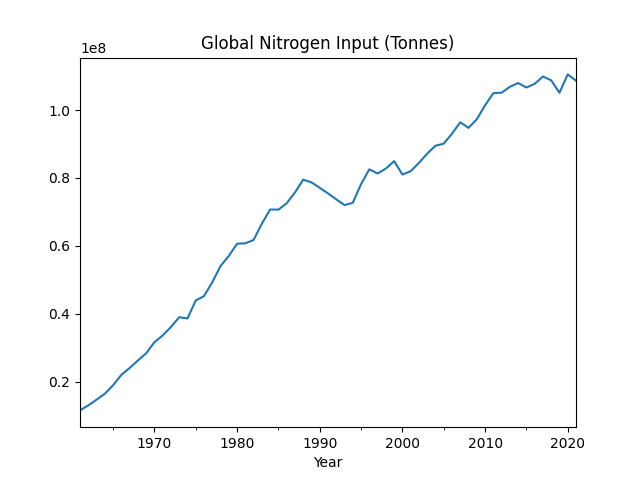

In [3]:
fert_series = pd.read_csv('../../../data/Agric_data/Global_fertiliser_input/FAOSTAT_data_en_2-20-2024.csv', parse_dates=['Year'])
fert_series.set_index('Year')[['Value']].plot(legend=False)
plt.title('Global Nitrogen Input (Tonnes)')
plt.show()

Nitrogen input level is considered a key indicator of land-use intensity [7], which in turn is a central driver of global biodiversity decline [1, 7 - 11] READ THESE AND CHECK RELEVANCE.

The ability to assess land-use intensity at scale, and implications for biodiversity, is therefore relevant to the decision-makers attempting to reconcile biodiversity strategies with social and economic constraints associated with the agricultural industry.

### Biodiversity data

Here I'm using data from the UK Pollinator Monitoring Scheme (PoMS) [12], which provides pan-trap records relating to systematic 1 km square surveys at 95 locations across the UK. The squares are visited four times per year for data collection. The UK PoMS is the only scheme in the world to conduct systematic pollinator survey data on pollinator species abundance at a national scale [13].

In [4]:
sample_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_samples.csv")
insect_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_insects.csv")

# X1km_square is the SW corner of the 1KM grid cell - so add 500m to centre the reference
sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'
insect_data['X1km_centre'] = insect_data['X1km_square'].str[:4].str.cat(insect_data['X1km_square'].str[4:], sep='5') + '5'

sample_data['geometry'] = sample_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)
insect_data['geometry'] = insect_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)

# Convert to datetime
sample_data['date'] = pd.to_datetime(sample_data['date'])
insect_data['date'] = pd.to_datetime(insect_data['date'])


# Count records
insect_data['count'] = insect_data['count'].astype(int)
insect_data.groupby('year')['count'].sum()

year
2017    2103
2018    3255
2019    4326
2020    1538
Name: count, dtype: int64

I select one year to proceed with to simplify the analysis - 2019 has the most records so we'll go with that.

In [5]:
insect_data = insect_data[(insect_data['year'] == '2019')]
sample_data = sample_data[(sample_data['year'] == '2019')]


# Convert to an equal-area projection with units metres - so all the study areas have the same area
insect_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)
sample_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

Calulcate biodiversity metrics for each location, pooling over sampling rounds [1]:
- Species richness: the number of unique species observed  (note there may be different sampling rates at different locations, check this)
- Species diversity (Shannon index): the number of unique species and their relative proportions
- Total abundance: sum of all individuals from all species

In [6]:
# Insect tount cols
count_cols = ['wasps_solitary',
              'wasps_social',
              'wasps_parasitic',
              'sawflies',
              'flies',
              'moths',
              'butterflies',
              'beetles_pollen',
              'beetles_other',
              'insects_small',
              'insects_other',
              'spiders',
              'all_invertebrates_excluding_bees_hoverflies',
              'bees',
              'hoverflies',
              'all_invertebrates_including_bees_hoverflies']

# Convert types
sample_data = sample_data.astype({**{'temperature_start': int, 'temperature_end': int, 'location_code': int}, **{col: int for col in count_cols}})
insect_data = insect_data.astype({'location_code': int})

In [7]:
# There's probably a peak, but just take the mean of temp as a representative temperature
sample_data['temperature_mean'] = (sample_data['temperature_start'] + sample_data['temperature_end'])/2

sample_data.groupby(['location_code', 'date']).agg(land_cover=pd.NamedAgg(column='land_cover', aggfunc='first'),
                                                   temperature_mean=pd.NamedAgg(column='temperature_mean', aggfunc='mean'),
                                                   **{i: pd.NamedAgg(column=i, aggfunc='sum') for i in count_cols}
                                                   )


# Calculate total abundance using sample data

land_cover  temperature_mean  wasps_solitary  \
location_code date                                                         
1             2019-05-14  agricultural              14.0               0   
              2019-06-20  agricultural              15.0               0   
              2019-07-29  agricultural              19.0               0   
              2019-08-24  agricultural              21.5               0   
2             2019-05-17  agricultural              15.0               0   
              2019-06-23  agricultural              16.7               0   
              2019-07-14  agricultural              17.4               0   
4             2019-05-18  agricultural              15.0               1   
              2019-06-23  agricultural              19.6               2   
              2019-07-28  agricultural              17.8               1   
              2019-08-26  agricultural              25.6               1   
5             2019-05-15  agricultural              15.0               0   
              2019-06-29  agricultural              22.8               0   
              2019-07-31  agricultural              18.7               9   
              2019-09-01  agricultural              14.2               3   
6             2019-05-02  agricultural              14.2               0   
              2019-06-14  agricultural              17.0               0   
              2019-07-02  agricultural              19.3               6   
              2019-08-22  agricultural              20.3               8   
7             2019-05-12  agricultural              14.1               0   
              2019-06-02  agricultural              16.5               0   
              2019-07-06  agricultural              17.5               0   
              2019-08-31  agricultural              17.5               3   
10            2019-05-30  agricultural              15.9               0   
              2019-07-03  agricultural              20.0               2   
13            2019-05-19  agricultural              18.2               3   
              2019-06-30  agricultural              18.2               2   
              2019-08-24  agricultural              21.4               7   
19            2019-06-26  agricultural              18.8               2   
              2019-08-08  agricultural              19.8               1   
              2019-08-28  agricultural              17.7               0   
22            2019-05-20  agricultural              15.6               0   
              2019-06-21  agricultural              16.8               0   
              2019-07-22  agricultural              24.5               0   
              2019-08-21  agricultural              19.5               1   
25            2019-05-13  agricultural              12.7               0   
              2019-06-14  agricultural              14.5               1   
              2019-07-16  agricultural              20.8               3   
              2019-08-12  agricultural              19.2               1   
27            2019-05-24  agricultural              19.0               0   
              2019-06-28  agricultural              19.5               2   
              2019-07-17  agricultural              23.0               1   
              2019-08-23  agricultural              21.0               5   
28            2019-05-16  agricultural              14.0               0   
              2019-07-16  agricultural              19.5               1   
              2019-08-29  agricultural              17.0               0   
31            2019-05-27  semi-natural              19.2               0   
              2019-07-01  semi-natural              15.5               0   
              2019-07-23  semi-natural              23.0               3   
              2019-09-03  semi-natural              16.0               0   
32            2019-06-27  semi-natural              21.3               0   


In [65]:
def shannon(array):
    _, counts = np.unique(array, return_counts=True)
    counts = counts.astype(float) / float(len(array))
    shannon = -np.sum(np.multiply(counts, np.log(counts)))

    return shannon


# Calculate hoverfly and bee abundance using occurrence data, as well as other biodiversity indices
def bee_hoverfly_metrics(group):
    abundance = len(group)
    species_richness = group['taxon_aggregated'].nunique() # Note the PoMS suggests use of taxon_aggregated for analysis, see documentation for explanation
    species_diversity = shannon(group['taxon_aggregated'].values) # Shannon
    
    return pd.Series({'abundance': abundance, 'species_richness': species_richness, 'species_diversity': species_diversity})


bee_hoverfly_biodiversity = insect_data.groupby(['location_code']).apply(bee_hoverfly_metrics)

For the purposes of estimating agricultural intensity in the vicinity of each sampling location, I consider a circle of radius 5 km centred on the sampling location. 

This represents a divergence from the methodology described in [1], where only the fields surveyed were selected for imagery analysis. As the S2 method is described for spring-sown cereals and there can be significant differences in vegetation indexes for different species CITE, and furthermore there is no guarantee that the PoMS survey locations are on spring-sown cereal fields, it is not possible to exactly replicate the methodology here.

Instead I look at the S2 imagery on grassland and cropland (specifically spring-sown cereals) in the vicinitiy of the PoMS sampling location to estimate the local land-use intensity proxy. To this end, I define a circle of radius two kilometres around the PoMS sampling location and calculation S2 indices on these areas.

Note that honey bees regularly travel this distance to forage, and have been witnessed more than 10 km from the hive [14], so defining a study zone around each sampling location in this way is not only practical within the constraints of the methodology here but also likely largely overlaps with areas frequented by the insects observed in the pan-traps.

### Satellite imagery and land-use data

#### Data download

Starting by identifying each PoMS location and define a corresponding bounding box to send with requests for data. Also define a lookup dictionary that holds information about each study area's geometry referenced by the PoMS location code.

In [9]:
sample_data['study_zone'] = sample_data.geometry.buffer(2e3)
sample_data['study_zone_bbox'] = shapely.box(*np.split(sample_data['study_zone'].bounds.values, 4, axis=1)).flatten()

location_geom_lookup = sample_data.drop_duplicates('location_code').set_index('location_code')[['geometry', # point at centre of study zone
                                                                                                     'study_zone', # circular zone around that point to be used for computation
                                                                                                     'study_zone_bbox', # bbox around that circular zone to be used for data download
                                                                                                    ]].to_dict(orient='index')

Now define a few helper functions to create download directories and handle requests to online data stores. Note that CROME data doesn't have an easy-access API yet so the download parameters are send to a bash script that sends a request to https://environment.data.gov.uk/explore/b498a2be-f3de-49fb-91a4-3381bb3868c2.

In [153]:
def create_zone_dir(dir_name):
    '''Builds local directory structure to download data into.'''
    base_path = '../../../data/Agric_data/Locations/'
    to_make = os.path.join(base_path, dir_name)
    if os.path.exists(to_make):
        return to_make
    else:
        os.mkdir(to_make)
        distributed_print('Created data dir at ' + to_make)
        return to_make

def read_S3(href, aoi_bbox_geodetic):
    '''Actually downloads the data and metadata corresponding to an S2 acquisition, based on a reference and spatial filter.'''
    with rasterio.open(href) as src:
        # Note that src crs may be different from the working crs in this notebook or lat/lon so transform to it!
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = transform_geodetic_to_s2(*aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(min(src_bbox[0]),
                                              min(src_bbox[1]), 
                                              max(src_bbox[0]), 
                                              max(src_bbox[1]),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}

def pass_clouds(thematic_data, max_cloud_perc=None):
    '''Filters acquisitions based on the area proportion of the image which is cloudy (according to the S2 cloud detection algorithm).'''
    medium_cloud_prob = np.sum(thematic_data == 8)
    high_cloud_prob = np.sum(thematic_data == 9)

    return 100 * ((medium_cloud_prob + high_cloud_prob) / np.size(thematic_data)) < max_cloud_perc

def clean_dir(path):
    '''Clears up directories if download is re-run.'''
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            distributed_print(f'### Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))

Create a client and AWS session to download data, and for each location in the PoMS data, download all 2019 S2 imagery and CROME land-use data.

In [99]:
# Instantiate a stac client to download the images
client = PyStackClient.open("https://earth-search.aws.element84.com/v1")

# Instantiate an AWS session to download S2 imagery
aws_session = rasterio.session.AWSSession(boto3.Session(),
                                         requester_pays=True)

# Create a transformer to map projected coords back to geodetic coords
transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(WORKING_CRS), 
                                                            pyproj.CRS('EPSG:4326'), 
                                                            always_xy=True).transform

# Choose which bands to download
band_names = ['red', 'nir', 'visual']

# Define mapping for crop designation
crome_lucode_map = dict(pd.read_csv('../../../data/Agric_data/CROME_LUCODE_LOOKUP.csv', sep=' \\\\t ', header=None, names=['lucode', 'cover']).values)

MAX_ITEMS = 1000

def handle_download_errors(_download_items):
    def log_and_skip_errors(_location_code):
        try:
            return _download_items(_location_code)
        except Exception as e:
            distributed_print(f'Location: {_location_code} :: ERROR (skipping) ' + str(e))
            return None

    return log_and_skip_errors
    
@handle_download_errors
def download_items(location_code):
    '''Downloads all S2 and CROME data for a given PoMS location.'''
    distributed_print(f'Location: {location_code} :: Starting location processing')
    dir_name = 'location_' + str(location_code )

    data_path = create_zone_dir(dir_name)

    # Skip this location if it was already processed
    if os.path.exists(os.path.join(data_path, 'metadata.csv')):
        distributed_print(f'Location: {location_code} :: Already processed, skipping')
        return None

    aoi_bbox = location_geom_lookup[location_code]['study_zone_bbox'] # in projected coords
    aoi_bbox_geodetic = transform_working_to_geodetic(*aoi_bbox.exterior.xy)
    aoi_geodetic_shapely = shapely.geometry.Polygon(np.stack(aoi_bbox_geodetic, axis=1))

    # For this AOI looks the crop map (CROME) data and identify relevant masks
    crome_dir = os.path.join(data_path, 'CROME')
    if 'CROME' in os.listdir(data_path):
        distributed_print(f'Location: {location_code} :: Already got CROME data, skipping download')
    else:
        subprocess.run('../../../data/Agric_data/get_crome.sh ' + \
                       '\"' + crome_dir + '\" ' + \
                       '\'' + f'{{"coordinates": {np.array2string(np.dstack(aoi_bbox_geodetic), precision=8, separator=",", suppress_small=True)},"type":"Polygon"}}'.replace("\n", "") + '\'',
           shell=True)

    # Search catalogue
    
    search = client.search(max_items=MAX_ITEMS, # can retrieve multiple tiles and processing levels so need more than yearly revisit count
                            collections=['sentinel-2-l2a'],
                           query={'s2:processing_baseline': {"neq": "05.00"}}, # Sentinel 2 reprocessing has not completed for 2019
                            # query=['eo:cloud_cover<50'],
                            bbox=[min(aoi_bbox_geodetic[0]),
                                  min(aoi_bbox_geodetic[1]), 
                                  max(aoi_bbox_geodetic[0]), 
                                  max(aoi_bbox_geodetic[1])],
                            datetime='2019')

    assert search.matched() < MAX_ITEMS, f'Location: {location_code} :: Need to request more items'

    # Now iterate through dates with S2 acquisitions and download if they're good enough (intersect PoMS location fully and not too many clouds)
    for item in search.items():
        # Store date reference
        date_ref = item.datetime.strftime('%Y_%m_%d')
        distributed_print(f'Location: {location_code}, Date: {date_ref} :: Starting acquisition processing') 
        
        base_write_path = os.path.join(data_path, date_ref)
        # If there is already a folder here and it contains the right number of files, consider this date to be processed and skip
        if os.path.exists(base_write_path) and (len(os.listdir(base_write_path)) == (len(band_names) + 2)):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Already have correct number of files, skipping')
            continue

        # First check this S2 capture fully covers the AOI
        if not shapely.geometry.shape(item.geometry).contains(aoi_geodetic_shapely):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: S2 acquisition did not fully cover AOI, skipping')
            continue

        # Next a cloud check
        s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
        max_cloud_perc = 10
        if not pass_clouds(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Too cloudy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability)')
            continue

        # Create write directory
        if not os.path.exists(base_write_path):
            os.mkdir(base_write_path)
        else:
            clean_dir(base_write_path)
            
        # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
        band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
        band_data['scl'] = s2_thematic
        
        # Calculate evi2
        evi2 = 2.5 * (band_data['nir']['data'].astype(np.float32) - band_data['red']['data'].astype(np.float32)) / (band_data['nir']['data'].astype(np.float32) + 2.4*band_data['red']['data'].astype(np.float32) + 1)
        evi2_profile = {**band_data['nir']['profile'].copy(), **{'nodata':np.nan, 'dtype': 'float32'}}
        band_data['evi2'] = {'data': evi2, 'profile': evi2_profile}
        

        # Write results, reprojecting everything into WORKING_CRS
        for band_name, data_profile in band_data.items():
            full_write_path = os.path.join(base_write_path, band_name + '.tif')

            ### REPROJECT: ###
            # Source bounds:
            transformer = rasterio.transform.AffineTransformer(data_profile['profile']['transform']) 
            left, top = transformer.xy(0,0, offset='ul')
            right, bottom = transformer.xy(data_profile['profile']['height'], data_profile['profile']['width'], offset='ul')
            
            # Get default transform
            transform, width, height = rasterio.warp.calculate_default_transform(data_profile['profile']['crs'], 
                                                                    WORKING_CRS, 
                                                                    data_profile['profile']['width'], 
                                                                    data_profile['profile']['height'], 
                                                                    left=left,
                                                                    bottom=bottom,
                                                                    right=right,
                                                                    top=top)
            _profile = data_profile['profile'].copy()
            _profile.update({'crs': WORKING_CRS,
                            'transform': transform,
                            'width': width,
                            'height': height})
            
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Writing to {full_write_path}')
            with rasterio.open(full_write_path, 'w', **_profile) as dst:
                for i in range(1, _profile['count'] + 1):
                    rasterio.warp.reproject(source=data_profile['data'],
                                            destination=rasterio.band(dst, i),
                                            src_transform=data_profile['profile']['transform'],
                                            src_crs=data_profile['profile']['crs'],
                                            dst_transform=transform,
                                            dst_crs=WORKING_CRS,
                                            resampling=rasterio.warp.Resampling.nearest)
    
    # Now create a file to hold any metadata we may want to add and also signals completion of this location's download            
    subprocess.run(['touch', os.path.join(data_path, 'metadata.csv')])

    return None

with rasterio.Env(aws_session):
    location_codes = sample_data['location_code'].unique()
    dask_client = DaskClient(threads_per_worker=4, n_workers=2)
    futures = []
    for location_code in location_codes:
        future = dask_client.submit(download_items, location_code)
        futures.append(future)
    
    dask_client.gather(futures)
        

# https://www.matecdev.com/posts/landsat-sentinel-aws-s3-python.html
# https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search

Location: 34 :: Starting location processing
Location: 34 :: Already processed, skipping
Location: 25 :: Starting location processing
Location: 25 :: Already processed, skipping
Location: 91 :: Starting location processing
Location: 91 :: Already processed, skipping
Location: 28 :: Starting location processing
Location: 28 :: Already processed, skipping
Location: 94 :: Starting location processing
Location: 94 :: Already processed, skipping
Location: 2 :: Starting location processing
Location: 2 :: Already processed, skipping
Location: 87 :: Starting location processing
Location: 87 :: Already processed, skipping
Location: 138 :: Starting location processing
Location: 138 :: Already processed, skipping
Location: 149 :: Starting location processing
Location: 149 :: Already processed, skipping
Location: 65 :: Starting location processing
Location: 110 :: Starting location processing
Location: 110 :: Already processed, skipping
Location: 65 :: Already processed, skipping
Location: 27 :: S

#### Full walkthrough for one location

Take a look at one location's output on a single date:

In [202]:
location_code = 25
date = '2019_03_25'


In [93]:
# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']
classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)



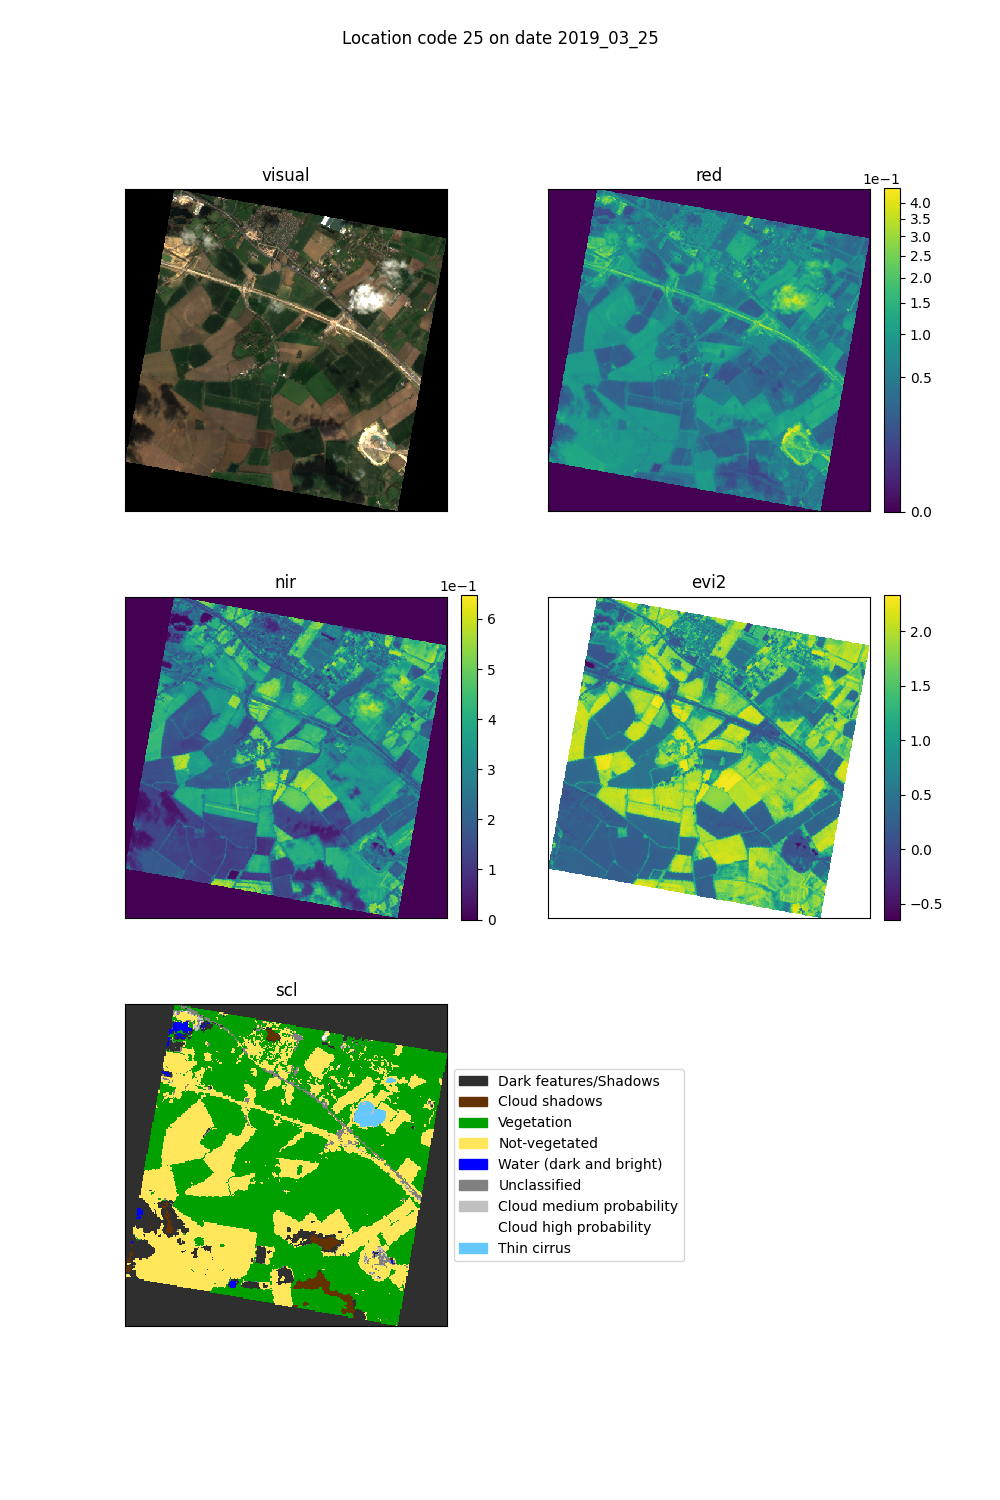

In [94]:
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 15))
axs = axs.ravel()

views = ['visual', 'red', 'nir', 'evi2', 'scl']
norms = [None, mpl.colors.PowerNorm(0.4), None, None, scl_norm]
cmaps = [None, None, None, None, scl_cmap]
for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', date, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   # extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.text(0.5, -0.05, f'({band_name})', horizontalalignment='center', transform=ax.transAxes)
    ax.set_title(band_name, wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.suptitle(f'Location code {location_code} on date {date}')
axs[-1].set_axis_off()
# fig.tight_layout()
plt.show()

Now use the S2 scene classification to mask out any "bad" pixels. Note that the SCL is lower resolution than the red and NIR bands so needs to be resampled for use with evi2.

In [13]:
def resample_scl(scl_path, ref_raster_path):
    with rasterio.open(scl_path) as src:
        with rasterio.open(ref_raster_path) as reference:
            # resample data to target shape
            scl_raw = src.read(1, out_shape=(int(reference.height),
                                             int(reference.width)),
                                  resampling=rasterio.enums.Resampling.nearest)

    return scl_raw
    

def get_scl_good_mask(location_code, date):
    '''Returns a mask that filters out "bad" pixels according to the S2 scene classification.'''
    scl_path = os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', date, 'scl.tif')
    evi2_path = os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', date, 'evi2.tif')
    
    scl_raw = resample_scl(scl_path, evi2_path)
            
    scl_good_mask = ~np.isin(scl_raw, [0, # No data
                                       1, # Saturated/defective pixel
                                       6, # Water
                                       9, # Cloud high prob
                                       11]) # Snow or ice

    return scl_good_mask
                               

        

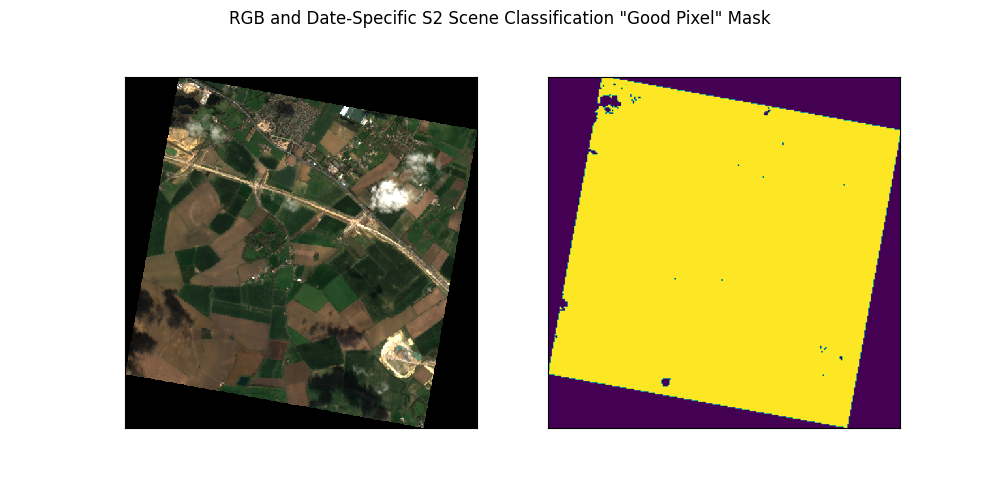

In [96]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(10, 5))
axs = axs.ravel()
ax = axs[0]
with rasterio.open(os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', date, 'visual.tif')) as src:
    rgb = src.read()
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

im = ax.imshow(np.squeeze(np.moveaxis(rgb, 0, -1)), 
               interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
               extent=extent)

ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
ax.imshow(get_scl_good_mask(location_code, date))
ax.set_xticks([])
ax.set_yticks([])
plt.suptitle('RGB and Date-Specific S2 Scene Classification "Good Pixel" Mask')

plt.show()




Define a second mask based on the SCL as pixels not labelled as vegetation on the entire year:

In [14]:
def get_scl_never_veg_mask(location_code):
    '''Returns a mask that filters out pixels not labelled as vegetation according to S2 SCL for the entire period.'''
    
    def mask_non_vegetation_scl(path):
        res = resample_scl(path, path.replace('scl.tif', 'evi2.tif')) != 4
        
        return res

    base_path = f'../../../data/Agric_data/Locations/location_{location_code}/*/scl.tif'
    scl_never_veg = ~functools.reduce(np.logical_and, [mask_non_vegetation_scl(i) for i in glob(base_path)])

    return scl_never_veg



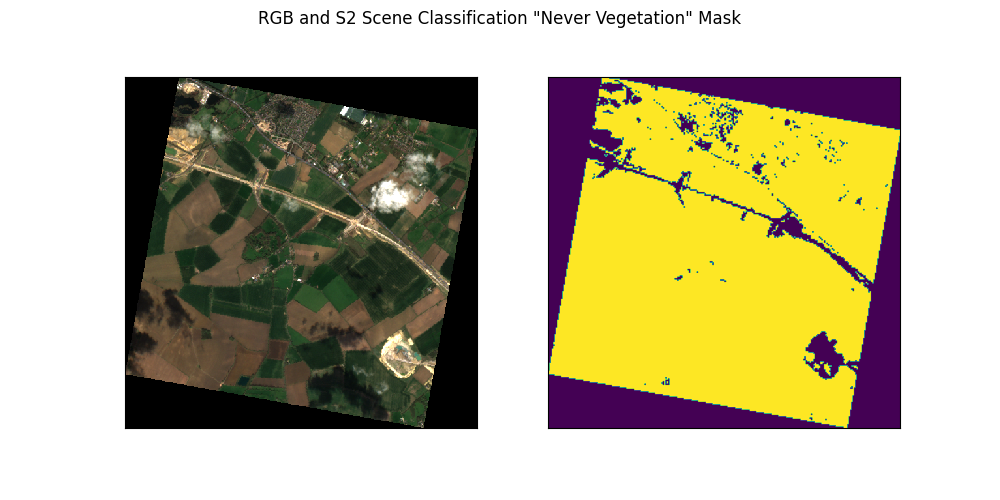

In [98]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(10, 5))
axs = axs.ravel()
ax = axs[0]
with rasterio.open(os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', date, 'visual.tif')) as src:
    rgb = src.read()
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

im = ax.imshow(np.squeeze(np.moveaxis(rgb, 0, -1)), 
               interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
               extent=extent)

ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
ax.imshow(get_scl_never_veg_mask(location_code))
ax.set_xticks([])
ax.set_yticks([])
plt.suptitle('RGB and S2 Scene Classification "Never Vegetation" Mask')

plt.show()

Now get masks based on crop designation. The method was originally applied to spring cereals [1], so return a spring cereal mask.

In [15]:
# To Do - test with a single AOI history, credit phenolopy
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


In [204]:
def rasterize_crome_mask(geoms, evi2_profile):
    mask = rasterio.features.rasterize(geoms, 
                                        out_shape=(int(evi2_profile['height']), int(evi2_profile['width'])),
                                        fill=0,
                                        transform=evi2_profile['transform'],
                                        default_value=1, 
                                        dtype='uint8').astype(bool)
    return mask

def get_crome_geoms(location_code):
    '''Reads crome data and converts to geometries on selected land-use codes.'''
    crome_path = os.path.join(f'../../../data/Agric_data/PoMS_Locations/location_{location_code}', 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_geoms = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.to_numpy()

    return spring_cereal_geoms


def get_farmed_area(location_code):
    '''Reads crome data and calculates the land area used for agriculture for this tile'''
    crome_path = os.path.join(f'../../../data/Agric_data/PoMS_Locations/location_{location_code}', 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_area = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()
    agric_area = crome_data[crome_data['lucode'].str.startswith(('AC', 'CA', 'LG', 'NU', 'TC', 'SR'))].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()

    return spring_cereal_area, agric_area

def get_cereal_grass_masks(location_code):
    '''Gets agricultural land-use masks based on CROME data.'''
    # For this location get CROME data (constant on a year)
    spring_cereal_geoms = get_crome_geoms(location_code)
    
    # Convert shapes to rasters based on raster profile of an evi2.tif for this location (should all have the same profile)
    evi2_path = glob(os.path.join(f'../../../data/Agric_data/PoMS_Locations/location_{location_code}', '*/evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile
    
    cereal_mask = rasterize_crome_mask(spring_cereal_geoms, evi2_profile)

    return cereal_mask



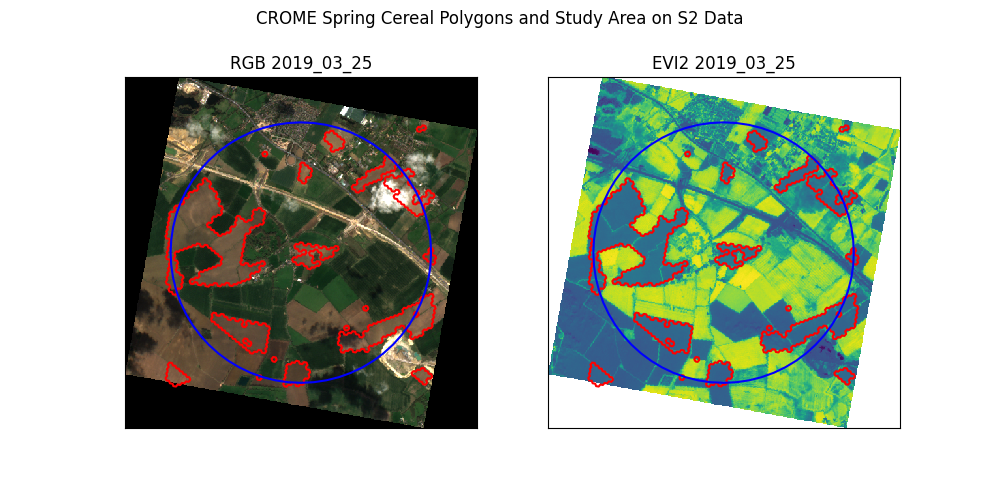

In [206]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(10, 5))
axs = axs.ravel()
ax = axs[0]
with rasterio.open(os.path.join(f'../../../data/Agric_data/PoMS_Locations/location_{location_code}', date, 'visual.tif')) as src:
    rgb = src.read()
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

im = ax.imshow(np.squeeze(np.moveaxis(rgb, 0, -1)), 
               interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
               extent=extent
              )

ax.set_title(f'RGB {date}', wrap=True)

spring_cereal_geoms = get_crome_geoms(location_code)
gpd.GeoSeries(spring_cereal_geoms, crs=WORKING_CRS).boundary.plot(ax=ax, color='red')
gpd.GeoSeries([location_geom_lookup[location_code]['study_zone'].exterior], crs=WORKING_CRS).plot(ax=ax, color='blue')

ax.set_xticks([])
ax.set_yticks([])


ax = axs[1]
with rasterio.open(os.path.join(f'../../../data/Agric_data/PoMS_Locations/location_{location_code}', date, 'evi2.tif')) as src:
    evi2 = src.read()
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]

im = ax.imshow(np.squeeze(evi2), 
               interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
               extent=extent
              )

ax.set_title(f'EVI2 {date}', wrap=True)

spring_cereal_geoms = get_crome_geoms(location_code)
gpd.GeoSeries(spring_cereal_geoms, crs=WORKING_CRS).boundary.plot(ax=ax, color='red')
gpd.GeoSeries([location_geom_lookup[location_code]['study_zone'].exterior], crs=WORKING_CRS).plot(ax=ax, color='blue')

ax.set_xticks([])
ax.set_yticks([])

plt.suptitle('CROME Spring Cereal Polygons and Study Area on S2 Data')
plt.show()




Note that the Sentinel 2 data and CROME data is requested with a bounding box defined in different coordinate reference systems, meaning the data layer extents do not align. 

#### Apply masks

In [102]:
cereal_mask = get_cereal_grass_masks(location_code)

evi2_paths = sorted(glob(os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', '*/evi2.tif')))

dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))

evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()

# Create masks (date-specific) based on SCL good pixels
good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(location_code, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                 coords=evi2_xr.coords,
                                  dims=('time', 'y', 'x'))

Plot results of masking:

Text(0.5, 0.98, 'Visual test of xarray masking #1')

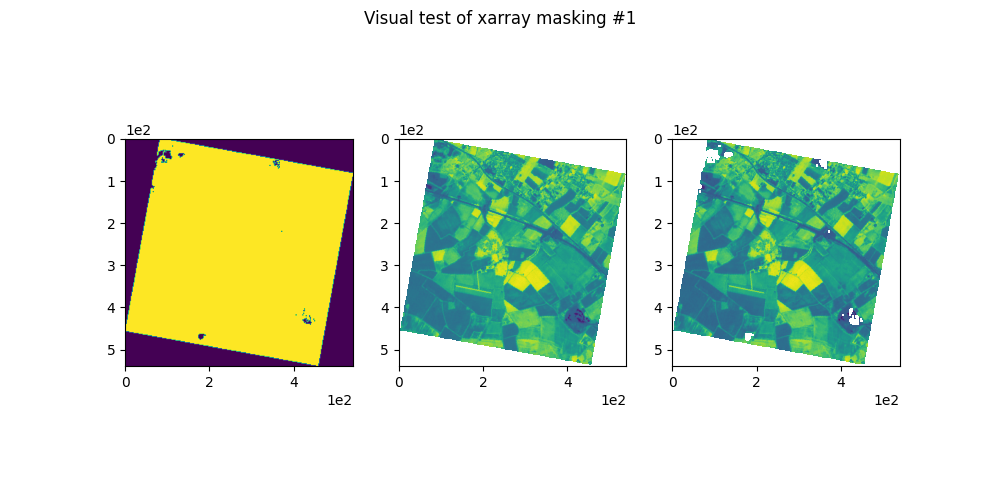

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(good_scl_masks_xr.isel(time=0))

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))

ax = axs[2]
ax.imshow(xr.where(good_scl_masks_xr, evi2_xr, np.nan).isel(time=0))

plt.suptitle("Visual test of xarray masking #1")

# xr.where(good_scl_masks_xr, evi2_xr, np.nan)

Text(0.5, 0.98, 'Visual test of xarray masking #2')

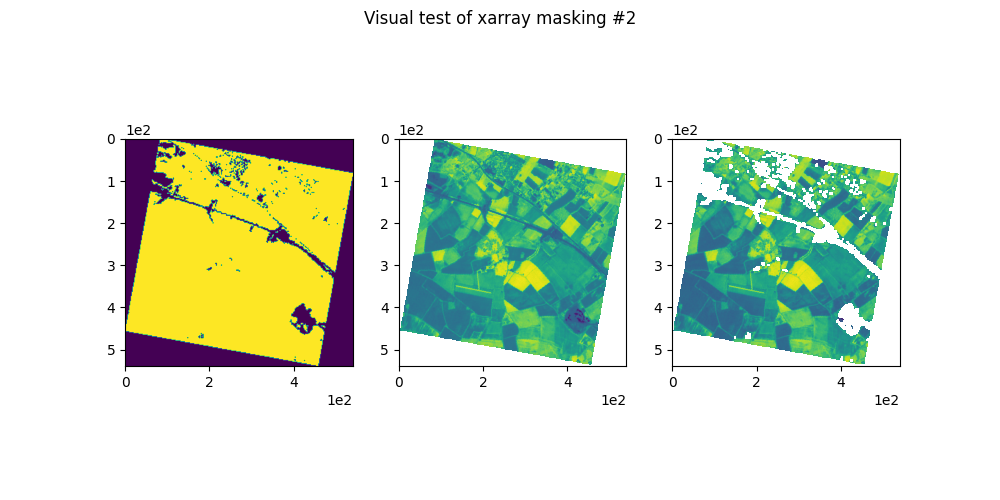

In [104]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(get_scl_never_veg_mask(location_code))

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))

ax = axs[2]
ax.imshow(xr.where(get_scl_never_veg_mask(location_code), evi2_xr, np.nan).isel(time=0), interpolation=None)

plt.suptitle("Visual test of xarray masking #2")


# xr.where(get_scl_never_veg_mask(location_code), evi2_xr, np.nan)

Text(0.5, 0.98, 'Visual test of xarray masking #3')

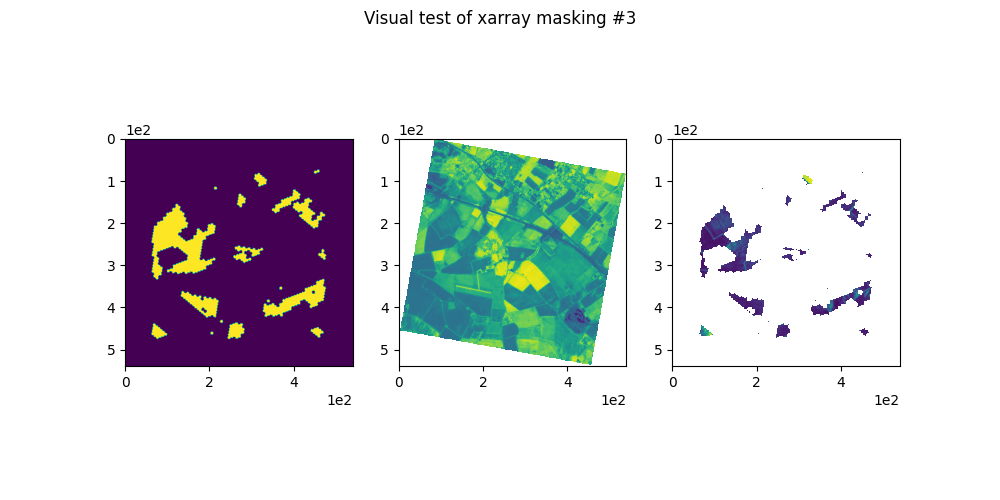

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(cereal_mask)

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))

ax = axs[2]
ax.imshow(xr.where(cereal_mask, evi2_xr, np.nan).isel(time=0), interpolation=None)

plt.suptitle("Visual test of xarray masking #3")


# xr.where(cereal_mask, evi2_xr, np.nan)

Create three masked xr datasets:

Text(0.5, 0.98, 'Visual test of xarray masking #6')

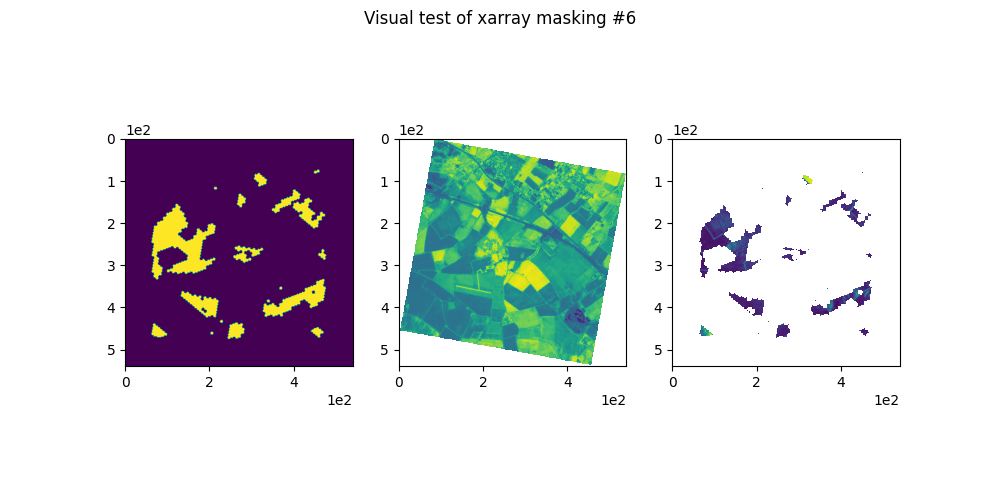

In [106]:
# Used chained where condition:

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(xr.where(cereal_mask, 
             xr.where(get_scl_never_veg_mask(location_code),
                      xr.where(good_scl_masks_xr, 1, 0), 0), 0).isel(time=0))

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))

ax = axs[2]
ax.imshow(xr.where(cereal_mask, 
             xr.where(get_scl_never_veg_mask(location_code),
                      xr.where(good_scl_masks_xr, 
                               evi2_xr, 
                               np.nan), 
                      np.nan), 
             np.nan).isel(time=0), interpolation=None)

plt.suptitle("Visual test of xarray masking #6")


Define evi2 xarray data arrays fully masked now:

In [107]:
evi2_cereal_xr = xr.where(cereal_mask, 
                          xr.where(get_scl_never_veg_mask(location_code),
                                   xr.where(good_scl_masks_xr, 
                                            evi2_xr, 
                                            np.nan), 
                                   np.nan), 
                          np.nan)


#### Phenology parameter calculations

As per https://github.com/lewistrotter/PhenoloPy/blob/main/Phenolopy.ipynb

Note that I've made a few minor fixes in my local version of the phenolopy module to make the functions play nicely with new xarray and numpy releases.

In [108]:
# Just do a bit of xarray preparation
evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})


In [109]:
# Redefine as a dataset
evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

In [110]:
evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



In [111]:
evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [112]:
# set resample interval now, as a few functions require it
interval = '2W'

evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



In [113]:
evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)


Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


In [114]:
evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



Calculate the phenology parameters using Phenolopy, modified slightly to follow methodology in [1] with a 5th percentile base level.

In [115]:
result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of fifth percentile veg index (bse_fifth_per) values.
> Calculating fifth percentile veg index (bse_fifth_per) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!


Amplitude (aos) of the vegetation index id defined as the peak value (max observed in the season) minus the base value (fifth percentile of veg index) and was found to have the strongest correlation with farmer reported yields, alongside peak EVI2 [1].

Text(0.5, 1.0, 'aos_values')

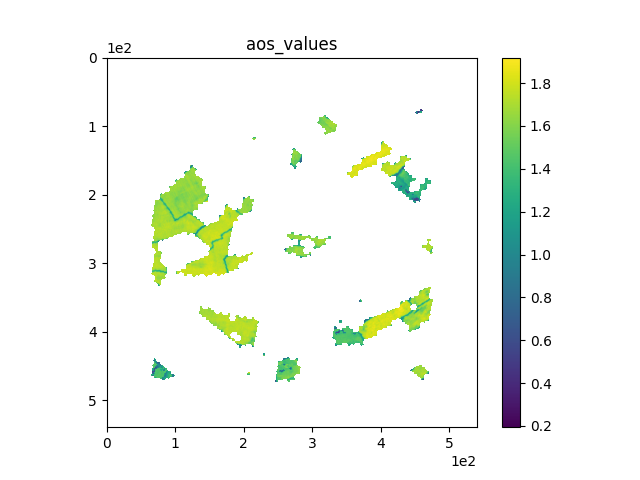

In [116]:
metric=2
plt.figure()
plt.imshow(result.isel(phen_metric=metric).to_numpy())
plt.colorbar()
plt.title(result.isel(phen_metric=metric)['phen_metric'].to_numpy().__str__())

Now plot the pixel-wise EVI2 time series, as well as the amplitude metric distribution for pixels labelled spring cereals according to CROME.

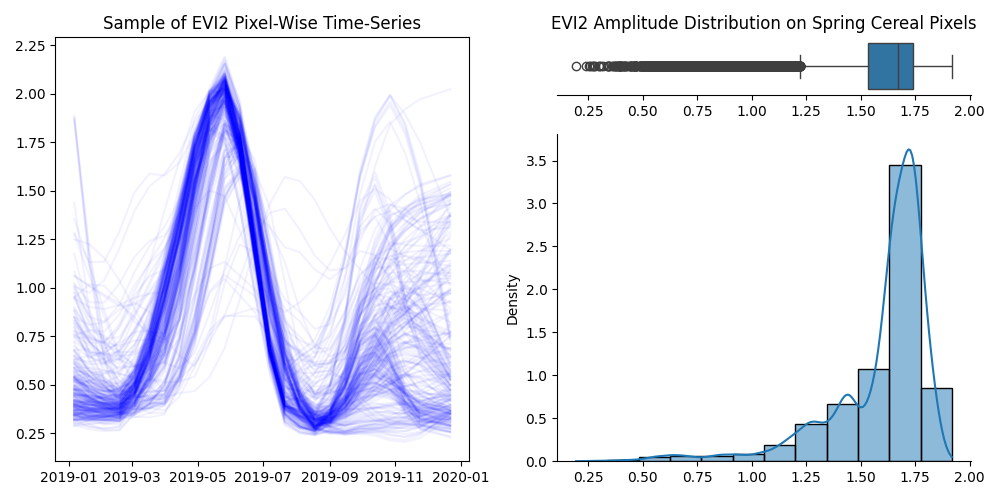

In [117]:
non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

# Create 2x2 sub plots
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(.15, .85))

plt.figure(figsize=(10, 5))

ax = plt.subplot(gs[:, 0]) 
for pixel_ref in range(0, veg_index_timeseries.shape[1], 100):
    ax.plot(evi2_cereal_xr.time, veg_index_timeseries[:, pixel_ref], color='b', alpha=0.05)
ax.set_title('Sample of EVI2 Pixel-Wise Time-Series')

_ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.boxplot(x=aos_vals, ax=_ax)
_ax.set(yticks=[])
sns.despine(ax=_ax, left=True)
_ax.set_title('EVI2 Amplitude Distribution on Spring Cereal Pixels')

ax = plt.subplot(gs[1, 1]) 
ax.sharex(_ax)
sns.histplot(x=aos_vals, bins=12, kde=True, stat='density', ax=ax)
sns.despine(ax=ax)


plt.tight_layout()
plt.show()




The long left tail in the amplitude distribution results from deficiencies with the CROME designation; in particular the CROME dataset:
- has a resolution coarser than that of Sentinel 2, hence when sampled at S2 (10m) resolution pixels which are not in the field are included;
- as a classification, is not perfect (it is produced by a random forest classifier); and,
- assumes a single crop per pixel per year for the designations chosen

The first two points mean that out-of-field pixels may be included, which very likely show lower EVI2 amplitudes than we see in the field, where there is a progression from bare earth to healthly crops. 

The last two points also may result in erroneous spring cereal amplitudes if a second crop, associated with a greater EVI2 peak is grown in the same year, though looking at the time series data below this should not be an issue as the greatest peak majoratively corresponds to a spring-sown crop, and other peaks are of a similar magnitude.

### Bulk process satellite imagery

In [10]:
location_codes = sample_data['location_code'].unique()

In [189]:
def get_aos(location_code):
    '''Returns the median evi2 amplitude on spring cereal fields in AOI'''
    distributed_print(f'Beginning processing for location {location_code}')
    try:
        cereal_mask = get_cereal_grass_masks(location_code)
        spring_cereal_area, agric_area = get_farmed_area(location_code)
        spr_cer_per = 100*spring_cereal_area/agric_area
        assert spr_cer_per > 5.0, "Spring cereal fields as percentage of farmed area less than threshold (5%), skipping"
    except Exception as e:
        distributed_print((location_code, e))
        return location_code, None
    
    evi2_paths = sorted(glob(os.path.join(f'../../../data/Agric_data/Locations/location_{location_code}', '*/evi2.tif')))
    dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
    evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()
    
    # Create masks (date-specific) based on SCL good pixels
    try:
        good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(location_code, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                     coords=evi2_xr.coords,
                                      dims=('time', 'y', 'x'))

    except ValueError as e:
        distributed_print((location_code, e))
        return location_code, None

    evi2_cereal_xr = xr.where(cereal_mask, 
                          xr.where(get_scl_never_veg_mask(location_code),
                                   xr.where(good_scl_masks_xr, 
                                            evi2_xr, 
                                            np.nan), 
                                   np.nan), 
                          np.nan)


    # Just do a bit of xarray preparation
    evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
    evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})

    # Redefine as a dataset
    evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
    evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

    evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

    evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)

    # set resample interval now, as a few functions require it
    interval = '2W'
    
    evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
    evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

    evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
    evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)

    evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

    result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

    non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
    veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
    aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

    distributed_print(f'Done processing {location_code}')

    return location_code, np.median(aos_vals)

In [190]:

dask_client = DaskClient(threads_per_worker=4, n_workers=2)
futures = []
for location_code in location_codes:
    future = dask_client.submit(get_aos, location_code)
    futures.append(future)

results = dask_client.gather(futures, errors='skip')
results = pd.DataFrame(results, columns=['location_code', 'median_aos']).dropna()
results.to_csv('../../../data/Agric_data/Locations/aos_results.csv')

Beginning processing for location 25
Beginning processing for location 34
Beginning processing for location 94
Beginning processing for location 2
Beginning processing for location 87


/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Beginning processing for location 91
Beginning processing for location 28
(87, ValueError('No valid geometry objects found for rasterize'))


/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Beginning processing for location 138
(138, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 177
Beginning processing for location 36
(36, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 108


/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current beha

(2, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 110


/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:26: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current beha

(91, AssertionError('Spring cereal fields as percentage of farmed area less than threshold (5%), skipping'))
Beginning processing for location 27


/tmp/ipykernel_155729/1271191953.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:26: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:26: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current beha

(108, AssertionError('Spring cereal fields as percentage of farmed area less than threshold (5%), skipping'))
Beginning processing for location 149


/tmp/ipykernel_155729/1271191953.py:26: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_155729/1271191953.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


(149, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 75
(75, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 73
(73, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 176
Done processing 94
Beginning processing for location 22
Done processing 34
Beginning processing for location 65
(65, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 67
(67, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 163
(163, ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location 1
Done processing 177
Beginning processing for location 10
Done processing 110
Beginning processing for location 76
(76, AssertionError('Spring cereal fields as percentage of farmed area less than threshold (5%), skipping'))
Beginning processing for location 157
(157, 

## Results

### Correlation between biodiversity and AOS

In [191]:
aos_vals = pd.read_csv('../../../data/Agric_data/Locations/aos_results.csv', index_col=0).set_index('location_code')

In [192]:
bio_aos = pd.merge(aos_vals, bee_hoverfly_biodiversity, left_index=True, right_index=True, how='left')

In [193]:
bio_aos

median_aos  abundance  species_richness  species_diversity
location_code                                                            
25               1.669695      108.0              29.0           2.931143
34               0.739178       93.0              27.0           2.732728
94               0.643424       45.0              24.0           2.976177
28               1.250893       47.0              18.0           2.299780
110              1.636076        3.0               2.0           0.636514
176              1.415727       55.0              23.0           2.926144
22               1.586517      130.0              39.0           3.207008
1                0.622874      159.0              35.0           2.695120
10               1.443116       26.0              15.0           2.459000
32               1.333322       36.0              16.0           2.436287
5                0.786882       67.0              25.0           2.725591
106              1.335374        7.0               5.0           1.475076
100              1.478244      109.0              25.0           2.548509
79               0.905548       21.0               9.0           1.838799
174              1.408726       34.0              17.0           2.715492
13               1.508570       52.0              16.0           2.069636
31               1.614650      106.0              25.0           2.484414
183              1.299074       84.0              30.0           2.910603

<Axes: xlabel='median_aos', ylabel='species_diversity'>

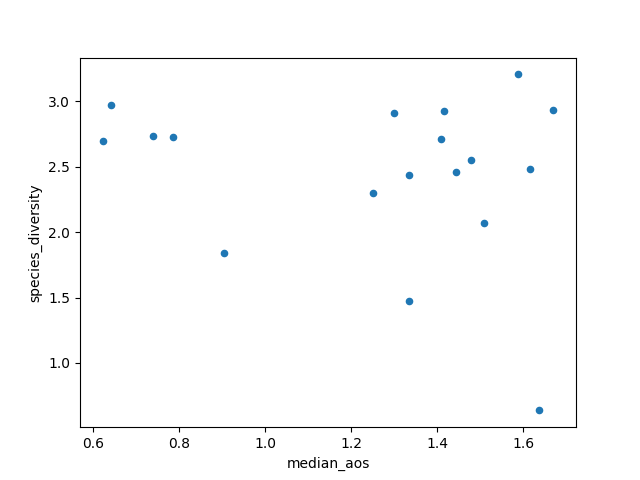

In [74]:
bio_aos.plot.scatter('median_aos', 'species_diversity')

In [194]:
pearsonr(bio_aos['median_aos'], bio_aos['abundance'])

PearsonRResult(statistic=-0.11223042119617023, pvalue=0.657494442170121)

In [78]:
pearsonr(bio_aos['median_aos'], bio_aos['species_richness'])

PearsonRResult(statistic=-0.18643618215169605, pvalue=0.45885812005526905)

In [79]:
pearsonr(bio_aos['median_aos'], bio_aos['species_diversity'])

PearsonRResult(statistic=-0.20707239015455237, pvalue=0.40968085619018163)

There isn't a significant correlation between any of the bee and hoverfly biodiversity measures and the S2 productivity parameters.

This does not align with the results detailed in [1]. Possible explanations include the following:
- The adaptations applied here (to work with PoMS data) render the methodology invalid, in particular the use of a 2.5km radius around the PoMS monitoring location for S2 parameter calculations; [1] takes only 4 in-field S2 pixels for each sampling location
- The assumption that nearby spring cereal evi2 amplitude effectively proxies local agricultural intensity is invalid. Spring cereal fields form a relatively small proportion of the farmed land, and an even smaller proportion of total land in the vicininty of each PoMS location.
- The sample size here is too small for generalization of the original method.
- The method [1] is not reproducible.

Can't conclude the final point as the methodology used here is substantively different from [1].

Some ideas to rectify issues:
1. Look at vascular plant diversity indices on the larger UK National Plant Monitoring Scheme; filter for sites in spring cereal fields across possible CROME dates; download only in-field S2 imagery and repeat analysis done here.
2. Take the larger PoMS citizen science FIT counts dataset, generate sufficient S2 indices across the study area and compare distributions.


__IYR vs PMS__ </br>
Look at IYR values on PMS data localities (potentially for this one look a PMS citizen science data instead of trap data). Identify areas for de-intensification of farming.:

Looking at the distribution of PMS indices with reference to honeybee-specific pesticide input to crop yield ratios (IYR) [2] can any potential priority areas for de-intensification be identified. Any particular risk zones?

## References

1. Abdi AM, Carrié R, Sidemo-Holm W, Cai Z, Boke-Olén N, Smith HG, Eklundh L, Ekroos J, Biodiversity Decline With Increasing Crop Productivity in Agricultural Fields Revealed by Satellite Remote Sensing. Ecological Indicators. 2021; 130():108098. https://doi.org/10.1016/j.ecolind.2021.108098. 
2. Bullock JM, Jarvis SG, Fincham WNW, Risser H, Schultz C, Spurgeon DJ, et al.. Mapping the Ratio of Agricultural Inputs to Yields Reveals Areas With Potentially Less Sustainable Farming. Science of The Total Environment. 2024; 909(): 168491. https://doi.org/10.1016/j.scitotenv.2023.168491.
3. https://stateofnature.org.uk/wp-content/uploads/2023/09/TP25999-State-of-Nature-main-report_2023_FULL-DOC-v12.pdf [Accessed 20/02/2024]
4. https://www.biorxiv.org/content/10.1101/2022.08.21.504707v2
5. Helen Phillips; Adriana De Palma; Ricardo E Gonzalez; Sara Contu et al. (2021). The Biodiversity Intactness Index - country, region and global-level summaries for the year 1970 to 2050 under various scenarios [Data set]. Natural History Museum. https://doi.org/10.5519/he1eqmg1
6. Structure of the agricultural industry in England and the UK at June
7. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2664376/
8. Agricultural intensification and the collapse of Europe's farmland bird populations.
9. Linking agricultural practice to insect and bird populations: a historical study over three decades.
10. Patterns and causes of species endangerment in Canada
11. Farming and the fate of wild nature
12. UK PoMS data download
13. https://uk-scape.ceh.ac.uk/our-science/projects/PoMS [Accessed 20/02/2024]
14. https://www.jstor.org/stable/1541
